# Vector Data in Python with Geopandas

As noted in our introductory reading, GIS data comes in two flavors -- vector data and raster data -- and in this reading, we'll be learning about the main package for working with vector geospatial data: Geopandas!

Like most tabular data we work with, geospatial vector data generally comes to us in the form of a table where each row constitutes a single observation, and each column constitutes a different variable. Unlike regular tabular data, however, each observation in vector data also contains information relating the observation to a location in the world. 

The term "vector data" comes from the fact that observations are linked to locations in the world by associating each observation with a geometric object -- a point, line, polygon -- and each of these geometric shapes is represented by a series of vertices (x-y coordinates) connected by straight lines. For example, we can represent this square:

![Unit Square](https://upload.wikimedia.org/wikipedia/commons/7/71/Unit_Square.svg)

with a vector consisting of the x-y coordinates of the corners of the square (the square's *vertices*): `[(0, 0), (1, 0), (1, 1), (0, 1)]` (image source: [Wikipedia](https://en.wikipedia.org/wiki/Unit_square#/media/File:Unit_Square.svg)).

The ability to represent the relationship between units of observation and locations on earth using these geometric shapes is extremely powerful. For example, we can use points to represent the locations of singular objects (e.g. stores, customers, cellphone towers, etc.), but we can also use lines to represent roads or rivers, and we can use polygons to represent units of observations that cover a specific area, such as countries, media markets, census blocks, etc. 

Moreover, as we'll see later, because these shapes are all represented using collections of coordinates in a two-dimensional plane, these different geometric shapes can interact easily. For example, it's easy to do things like a "spatial join" where we pull all the rows in one dataset that have customers (represented by points) that are physically located inside a media market (represented by a polygon) in another dataset based only on their spatial relationship to one another.

## Wait, Only Two Dimensions?

At this point, some careful readers may be saying to themselves: "Uh... hey: how are we just storing the vertices of these shapes as x-y coordinates? The world isn't flat, so how are we representing everything in two dimensions?"

Great question careful reader! The short answer is that when working with GIS data, we almost always treat our data as two-dimensional because we can employ some tricks to *project* locations on the round Earth into a two-dimensional plane, and working in two-dimensions is *much* easier than working in three. We'll talk a lot more about how this is done (because there are a lot of important nuances in how we choose to project locations onto a two-dimensional plane), but for the moment, it's enough to know that we can do it! 

Indeed, you're almost surely already familiar with one trick we use to do this: latitude and longitude coordinates! Every location on the surface of the Earth can be identified by specifying a latitude and longitude, which are (in effect) just x-y coordinates.

So for the moment, if thinking about coordinates in two dimensions feels odd, just think of these coordinates as latitudes and longitudes. 

As mentioned in our [last reading](gis_what_is_gis.ipynb), though, and as we'll discuss in detail in a later reading, we definitely aren't limited to latitude and longitude -- indeed, the tools we're using can be used for any representation of locations in two dimensions, like locations in a warehouse or on a football field!

## Geopandas

Because vector spatial data is essentially just regular tabular data + a geometric shape associated with each row, in this course we will be using a library called Geopandas that, as the name implies, is based on Pandas. In effect, Geopandas represents vector spatial data as a pandas DataFrame that includes an object column that contains the geometric shape associated with each row (something it calls a GeoDataFrame)! To illustrate, here's the GeoDataFrame of all the countries in the world we saw in the last reading:

In [1]:
import geopandas as gpd
import numpy as np

# Load GIS data
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Look at the data
world.sample(5)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
170,3856181,Europe,Bosnia and Herz.,BIH,42530.0,"POLYGON ((18.56000 42.65000, 17.67492 43.02856..."
93,55123814,Asia,Myanmar,MMR,311100.0,"POLYGON ((100.11599 20.41785, 99.54331 20.1866..."
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
50,2484780,Africa,Namibia,NAM,25990.0,"POLYGON ((19.89577 -24.76779, 19.89473 -28.461..."
30,11138234,South America,Bolivia,BOL,78350.0,"POLYGON ((-69.52968 -10.95173, -68.78616 -11.0..."


<AxesSubplot:>

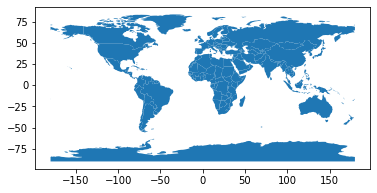

In [2]:
world.plot()

Crucially, this means that GeoDataFrames support all the operations you're familiar with from pandas, including merging, subsetting, etc. In fact, geopandas isn't just based on Pandas in an abstract sense -- the way geopandas is written is by "inheriting" the DataFrame object from pandas then adding to it. So as soon as something changes in pandas, those changes will propagate to geopandas as well. 

(Honestly, this may be one of the only instances I've ever seen of the inheritance idea from object-oriented programming actually working incredibly well).

To illustrate:

<AxesSubplot:>

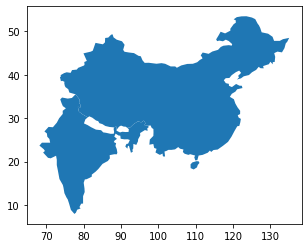

In [3]:
# Get countries whose population is at least 10x the 
# average county population
big_countries = world[world.pop_est > world.pop_est.mean() * 10]

# And plot the subsets
big_countries.plot()

China and India! Great. 

Also, note the axes -- as noted above, one example of how we represent spatial data in two dimensions is by making our x-y coordinates equal to latitudes and longitudes, and that's precisely the representation being used by this data. Indeed, if we try to look at the actual shape object for a single country (say, India, which is located between 70 and 100 degrees Longitude (x-coordinate) and between 10 and 40 degrees of Latitude (y-coordinate)), we can see India is represented by a `POLYGON` object whose vertices all have values in that range, as we'd expect:

In [4]:
world.loc[world.name == "India", "geometry"]

98    POLYGON ((97.32711 28.26158, 97.40256 27.88254...
Name: geometry, dtype: geometry

### OK, so what makes Geopandas different?

Geopandas is *basically* just pandas with a column for spatial data, but that's not *all* it is. It also includes the following features we'll explore below:

- **Reading and Writing Spatial Data:** Spatial data has a number of standard data formats (shapefiles, geojson, etc.), and geopandas provides tools for reading and writing to all these formats (yay!).
- **Measuring Spatial Relationships:** Geopandas is deeply integrated with libraries for geometric manipulations, making it easy to do things like measure the distances between points in your data (say, to see if your sales people are spread out efficiently). And as mentioned before, one great uses of GIS is to link records from different databases based on locality -- say, pulling the records of all census blocks within a mile of where you might be adding a new store.
- **Projection Management:** A geodataframe includes an attribute (the Coordinate Reference System, or CRS) that keeps track of the projection used to convert locations on the Earth into the x-y coordinates in the shape objects (which are just floating point numbers). In the case of the `world` geodataframe we saw above, for example, the geodataframe's CRS just says "hey, the x-y coordinates used here are latitude and longitudes". So your geodataframe stores this information, and provides some tools for moving from one projection to another. 
- **Mapping:** As you've already seen, geopandas makes simple maps easy to generate.
- **Tools for Geometric Manipulations:** The utility of these tools are a little tricky to explain at this point, but geopandas has tools for doing things like taking points and expanding them into circles of a given diameter, or intersecting polygons.

So while geopandas is great in that it should feel very familiar, don't be fooled into thinking it doesn't also have a lot of extra skills to offer. 

(Note: all these abilities are rooted in other libraries that geopandas integrates into a single tool, so if you start reading about GIS in Python, you're likely to come across references to libraries like Shapely, PyGEOS, fiona, pyproj, etc. Those aren't really "alternatives", but rather libraries that can be used independently, but which are integrated into geopandas.)


## The Geometry Column

One key organizing concept for a GeoDataFrame is that it only ever has one active "official geometry" column -- that is, a column with geometric objects that are used when doing spatial operations. By default, this column is named `geometry`, but that need not be the case -- the column that is the active "official geometry" column is the one whose name is stored in `gdf.geometry.name`. So for our world dataset, that column is currently the `geometry` column:

In [5]:
world.geometry.name

'geometry'

But we could change it. Suppose we wanted to create a new column in our dataset that contained the centroid (think the "center point") of each country -- we can do that with `.centroid` (we'll talk more about these kinds of geometric manipulations later, don't worry!):

(Note we'll get an error here telling us we shouldn't be calculating distances using a "geographic CRS". As with the area calculation in our [first reading](gis_what_is_gis.ipynb), its telling us something important, but something we won't discuss till our [reading on projections](gis_projections_and_crs.ipynb). MIDS students, I'll make you read that next -- if you're just coming to this through google, *please* be sure to read that after this!).

In [6]:
world["country_centroids"] = world.centroid
world.sample(3)

/var/folders/tj/s8f2_ks15h315z5thvtnhz8r0000gp/T/ipykernel_80132/1055431317.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world["country_centroids"] = world.centroid


,pop_est,continent,name,iso_a3,gdp_md_est,geometry,country_centroids
35,6025951,North America,Nicaragua,NIC,33550.0,"POLYGON ((-83.65561 10.93876, -83.89505 10.726...",POINT (-85.02032 12.84819)
40,31304016,South America,Venezuela,VEN,468600.0,"POLYGON ((-60.73357 5.20028, -60.60118 4.91810...",POINT (-66.16383 7.16213)
148,31381992,Asia,Malaysia,MYS,863000.0,"MULTIPOLYGON (((100.08576 6.46449, 100.25960 6...",POINT (109.69815 3.72559)


We can see we now have two columns with geometric objects in them: `geometry` and `country_centroids`. But if I try and do a spatial operation -- e.g. making a map -- we'll see the GeoDataFrame still gives primacy to the `geometry` column:

<AxesSubplot:>

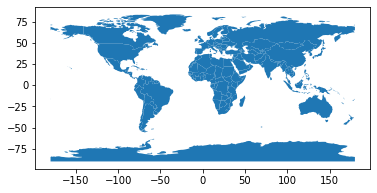

In [7]:
world.plot()

But if I *change* the "official geometry" column with `world.set_geometry("country_centroids")` and then plot the data again, we now see its plotting the centroids:

<AxesSubplot:>

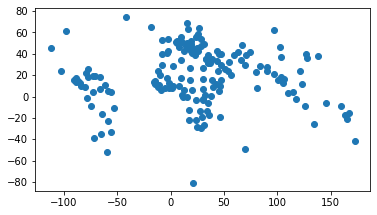

In [8]:
world = world.set_geometry("country_centroids")
world.plot()

Is it confusing that `world` still has a column called "geometry" that isn't *the* "official geometry" column? Yes. Yes it is. Which is why I keep using the term "official geometry" in quotes to refer to the column being given primacy for spatial operations. But that's just something *I'm* doing here -- geopandas just allows for having two things with the same name (here, a column named "geometry" holding the country polygons and the attribute that dictates which column is the "official geometry" column).

So... that's just a thing you have to deal with!

## Maps

We'll finish off our introduction to geopandas with a quick note on mapping. As we saw above, the `.plot()` command is an easy way to create maps in geopandas, and as we saw in our [intro reading](gis_what_is_it.ipynb) if you also pass a column name, it will color each observation based on the value of that variable (with respect to the usual arguments you might pass to matplotlib, like `cmap` to control the color map):

<AxesSubplot:>

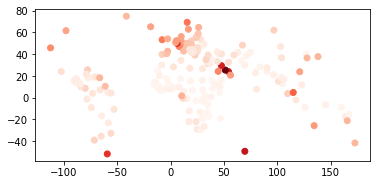

In [9]:
world["gdp_per_cap"] = world["gdp_md_est"] / world["pop_est"]
world = world[world["name"] != "Antarctica"]
world.plot("gdp_per_cap", cmap="Reds")

Oops! See, I forgot to change the "official geometry" column back. And now I'm gonna leave that mistaken in here as a learning opportunity. :) 

<AxesSubplot:>

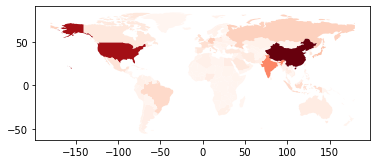

In [10]:
world = world.set_geometry("geometry")
world.plot("gdp_md_est", cmap="Reds")

You can read more about this [basic mapping functionality here](https://geopandas.org/en/stable/docs/user_guide/mapping.html). But...

### Altair and Geopandas

You can also make Altair maps with [gpdvega](https://iliatimofeev.github.io/gpdvega/), and you can make...

### Interactive Maps

interactive maps natively in geopandas with the `.explore()` method! This isn't something I can get to easily embed in this website (sometimes it works, so I'll leave it below?), so you can see it [live over here](https://geopandas.org/en/stable/docs/user_guide/interactive_mapping.html) and/or try it yourself!

In [11]:
world.explore()

## What's Next

There's much more to come! Next up we'll discuss how we can relate different geodataframes, manipulate geometric objects, data formats, and we'll finally talk about these projection / CRS things I keep avoiding addressing!

So first, [let's read about relating different datasets!](gis_relating_data.ipynb)